In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords 
from collections import Counter
import os

C:\Users\Ming Xuan\AppData\Local\Temp\ipykernel_4080\2238641776.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_data(files):

    data_path = os.getcwd()+'/Data/'
    combined_df = pd.DataFrame(columns=['text', 'label'])
    df_columns = ['text', 'label']
    
    for x in files:

        df = pd.read_csv(data_path+x)
        df = df[df.columns[:2]]
        df.columns = df_columns
        df['text'] = df['text'].astype(str)

        combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df

In [3]:
files = ['dataset1.csv', 'dataset2.csv', 'dataset3.csv', 'dataset4.csv']#, 'dataset5.csv']

data_df = get_data(files)
data_df

C:\Users\Ming Xuan\AppData\Local\Temp\ipykernel_4080\622898227.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([combined_df, df], ignore_index=True)


,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0
...,...,...
32511,"""Nothing beats the feeling of achieving someth...",0.0
32512,Too much homework Feeling Stressed!,1.0
32513,"overworked in school,, causes me headache",1.0
32514,How come my friends immediately get to know st...,0.0


In [4]:
data_df['label'].value_counts()

label
0.0    24406
1.0     8105
Name: count, dtype: int64

In [5]:
def even_out_dataframe(df):

    counts = df['label'].value_counts()

    if counts[0] > counts[1]:
        desired_count = counts[1]
        label = 0
        non_label = 1
    else:
        desired_count = counts[0]
        label = 1
        non_label = 0

    df_balanced = pd.concat([df[df['label'] == label].sample(desired_count), df[df['label'] == non_label]], ignore_index=True)
    
    return df_balanced

In [6]:
balanced_df = even_out_dataframe(data_df)
print(balanced_df['label'].value_counts())

data_df = balanced_df

label
0.0    8105
1.0    8105
Name: count, dtype: int64


In [7]:
data_df

,text,label
0,Seeing the sunny weather this morning after it...,0.0
1,I think a girl looks cute when she's happy or ...,0.0
2,"@sarazarr GREAT! I didn't make out with you, b...",0.0
3,"""Julie Andrews"" Switzerland â™¥â '™ðŸ‡¨ðŸ‡.Swe...",0.0
4,wanted to tweet that i wa in victoria but sill...,0.0
...,...,...
16205,Depressed & alone,1.0
16206,I blame school for my anxiety,1.0
16207,“If anyone could help me get through a problem.”,1.0
16208,Too much homework Feeling Stressed!,1.0


In [8]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

C:\Users\Ming Xuan\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BERT tokenizer...


In [9]:
max_len = 0

sentences = data_df['text']

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

    

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (856 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  4382


In [10]:
sentences = data_df['text']
labels = data_df['label']

In [11]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Ming Xuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Seeing the sunny weather this morning after it rained for 4 days, mothers were excited to take out the laundry and take action, after that they smiled with relief looking at the clothesline in the hot sun and "Let's sunbathe" don't get vitamin D deficiency the cost of treating covid is "expensive" he said ðŸ ❤
Token IDs: tensor([  101,  3773,  1996, 11559,  4633,  2023,  2851,  2044,  2009, 28270,
         2005,  1018,  2420,  1010, 10756,  2020,  7568,  2000,  2202,  2041,
         1996, 14533,  1998,  2202,  2895,  1010,  2044,  2008,  2027,  3281,
         2007,  4335,  2559,  2012,  1996,  4253,  4179,  1999,  1996,  2980,
         3103,  1998,  1000,  2292,  1005,  1055,  3103, 14479,  5369,  1000,
         2123,  1005,  1056,  2131, 17663,  1040, 18888,  1996,  3465,  1997,
        12318,  2522, 17258,   102])
tensor([0., 0., 0.,  ..., 1., 1., 1.], dtype=torch.float64)


### Transform labels to 1 hot encoding

In [13]:
num_classes = labels.max().item() + 1

labels = labels.int()

labels_saved = labels
labels = torch.eye(num_classes)[labels]

print(labels)
print(len(labels))

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]])
16210


In [14]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.
TRAIN_SIZE = 0.8

# Calculate the number of samples to include in each set.
train_size = int(TRAIN_SIZE * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

12,968 training samples
3,242 validation samples


In [36]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [44]:
from transformers import BertModel

bert_model = BertModel.from_pretrained("google-bert/bert-base-uncased")
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [45]:
import torch.nn as nn

class BERT_added_layers(nn.Module):
    def __init__(self):
        super(BERT_added_layers, self).__init__()
        
        self.base_model = bert_model

        for param in self.base_model.parameters():
            param.requires_grad = False
            
        self.tahn = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 768)
        self.linear2 = nn.Linear(768, 768)
        self.linear4 = nn.Linear(768, 768)
        self.linear3 = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_ids, attn_mask):
        output = self.base_model(input_ids, attention_mask=attn_mask)

        output = self.linear1(output[0][:,0,:].view(-1,768))
        output = self.tahn(output)
        output = self.linear2(output)
        output = self.dropout(output)
        output = self.linear4(output)
        output = self.dropout(output)
        output = self.linear3(output)
        output = self.sigmoid(output)
        
        return output
    
model = BERT_added_layers()

In [46]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-8:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 207 different named parameters.

==== Embedding Layer ====

base_model.embeddings.word_embeddings.weight            (30522, 768)
base_model.embeddings.position_embeddings.weight          (512, 768)
base_model.embeddings.token_type_embeddings.weight          (2, 768)
base_model.embeddings.LayerNorm.weight                        (768,)
base_model.embeddings.LayerNorm.bias                          (768,)

==== First Transformer ====

base_model.encoder.layer.0.attention.self.query.weight    (768, 768)
base_model.encoder.layer.0.attention.self.query.bias          (768,)
base_model.encoder.layer.0.attention.self.key.weight      (768, 768)
base_model.encoder.layer.0.attention.self.key.bias            (768,)
base_model.encoder.layer.0.attention.self.value.weight    (768, 768)
base_model.encoder.layer.0.attention.self.value.bias          (768,)
base_model.encoder.layer.0.attention.output.dense.weight   (768, 768)
base_model.encoder.layer.0.attention.output.dense.bias        

In [47]:
from sklearn.metrics import f1_score, precision_score, recall_score


def f1_score_func(preds, labels):
    # Takes in 2 tensors

    preds, labels = preds.cpu().detach().numpy(), labels.cpu().detach().numpy()

    f1 = f1_score(labels, preds, average = 'weighted')
    p_score = precision_score(labels, preds)
    r_score = recall_score(labels, preds)
    
    return f1, p_score, r_score

def validate(model, valloader, val_dataset, device, criterion):
    model.eval()
    val_loss = 0.0
    running_corrects = 0
    batch_no = 0
    running_f1 = 0
    running_p_score = 0
    running_r_score = 0
    predicted_list, labels_list = [], []
    
    for batch in valloader:
        batch_no += 1
        tensor1, attn_mask,  label = batch[0], batch[1], batch[2]
        tensor1, attn_mask, label = tensor1.to(device), attn_mask.to(device), label.to(device)
        label = torch.argmax(label, dim=1).reshape(-1, 1)
        with torch.no_grad():
            output = model(tensor1, attn_mask)
            preds = output>0.5
            loss = criterion(output, label.float())
            
        val_loss += loss.item()
        running_corrects += torch.sum(preds == label)

        f1, p_score, r_score = f1_score_func(preds, label)
        running_f1 += f1
        running_p_score += p_score
        running_r_score += r_score

        predicted_list.extend(preds.cpu())
        labels_list.extend(label.cpu())
    
    val_loss /= len(val_dataset)
    val_acc = running_corrects.item()/len(val_dataset)
    f1 = running_f1/batch_no
    p_score = running_p_score/batch_no
    r_score = running_r_score/batch_no

    return val_loss, val_acc, f1 , p_score, r_score, predicted_list, labels_list

def train(model, trainloader, train_dataset, optimizer, device, criterion, scheduler = None):
    model.train()
    train_loss = 0.0
    running_loss = 0.0
    running_corrects = 0

    for batch in trainloader:
        optimizer.zero_grad()
        
        tensor1, attn_mask,  label = batch[0], batch[1], batch[2]
        tensor1, attn_mask, label = tensor1.to(device), attn_mask.to(device), label.to(device)
        output = model(tensor1, attn_mask)

        preds = output>0.5
        label = torch.argmax(label, dim=1).reshape(-1, 1)
        
        loss = criterion(output, label.float())
        
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
        
        train_loss += loss.item()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == label)

    train_loss /= len(train_dataset)
    train_acc = running_corrects.item()/len(train_dataset)

    return train_loss, train_acc

In [48]:
import random
import numpy as np
from utils.early_stopper import EarlyStopper
from transformers import get_linear_schedule_with_warmup

lr = 0.005
optimizer = torch.optim.AdamW(params= model.parameters(), lr = lr)
criterion = nn.BCELoss()

epochs = 30
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

patience = 3
early_stopper = EarlyStopper(patience=patience, min_delta=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epoch = 50
best_epoch = 0
best_val_acc = 0

history = []
accuracy = []

model = model.to(device)

for epoch in range(num_epoch):
    
    train_loss, train_acc = train(model, train_dataloader, train_dataset, optimizer, device, criterion)
    val_loss, val_acc, f1 , p_score, r_score, predicted_list, labels_list  = validate(model, validation_dataloader, val_dataset, device, criterion)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch

        stored_predicted_list, stored_labels_list = predicted_list, labels_list

        # save_path = os.getcwd() +'\\models\\{}_best.pt'.format(name)
        # torch.save(model.state_dict(), save_path)

    print('[{}], \ttrain loss: {:.5}\tacc: {:.5}'.format(epoch+1, train_loss, train_acc))
    print('[{}], \tval loss: {:.5}\tacc: {:.5}\tf1: {:.5}\tp_score: {:.5}\tr_score: {:.5}'.format(epoch+1, val_loss, val_acc, f1 , p_score, r_score))

    if early_stopper.early_stop(val_loss):
        print("Done! Early stopped at {}".format(epoch))
        break
    

[1], 	train loss: 0.010068	acc: 0.86151
[1], 	val loss: 0.0080396	acc: 0.8942	f1: 0.89412	p_score: 0.86368	r_score: 0.93594
[2], 	train loss: 0.0084768	acc: 0.88788
[2], 	val loss: 0.0075482	acc: 0.91271	f1: 0.91312	p_score: 0.9519	r_score: 0.87122
[3], 	train loss: 0.0083733	acc: 0.89158
[3], 	val loss: 0.0072699	acc: 0.90407	f1: 0.90379	p_score: 0.87159	r_score: 0.94664
[4], 	train loss: 0.0078719	acc: 0.89813
[4], 	val loss: 0.0069683	acc: 0.91178	f1: 0.91189	p_score: 0.9725	r_score: 0.85007
[5], 	train loss: 0.0075396	acc: 0.90022
[5], 	val loss: 0.0067443	acc: 0.92042	f1: 0.92111	p_score: 0.93272	r_score: 0.90824
[6], 	train loss: 0.0078118	acc: 0.90238
[6], 	val loss: 0.0079275	acc: 0.90376	f1: 0.90317	p_score: 0.98016	r_score: 0.82589
[7], 	train loss: 0.0070089	acc: 0.90932
[7], 	val loss: 0.0062926	acc: 0.92196	f1: 0.92179	p_score: 0.91805	r_score: 0.92494
[8], 	train loss: 0.0069498	acc: 0.91194
[8], 	val loss: 0.0060914	acc: 0.92104	f1: 0.9216	p_score: 0.90988	r_score: 0.935

In [51]:
best_epoch

10

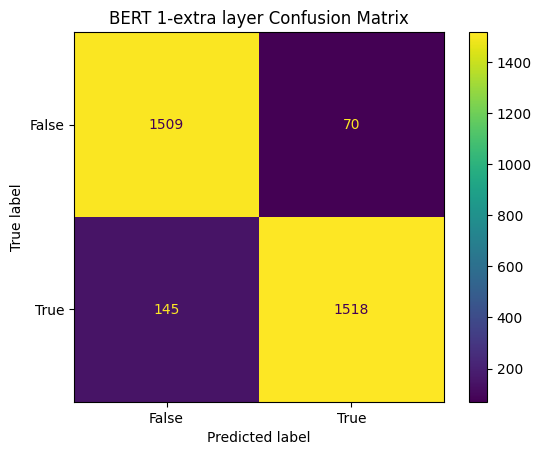

In [50]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(stored_labels_list, stored_predicted_list)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])


cm_display.plot()
plt.title("BERT 1-extra layer Confusion Matrix")
plt.show()

In [60]:
A = 'All I feel is anxiety'
B = 'naruto is a great anime'
C = 'I dont feel anything anymore'
D = 'Lets have a picnic today!'
E = 'I am wondering why there is so much talk about depression these days'
F = 'I have never been happier'

sentences = [A,B,C,D,E,F]

input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])

model.cpu()

for x in range(len(input_ids)):

    predicted = model(input_ids[x])
    print(predicted[0][0])
    predicted = np.argmax(predicted[0][0].detach().numpy())


    print("For ({}) : {}".format(sentences[x], predicted))

c:\Users\Ming Xuan\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


TypeError: BERT_added_layers.forward() missing 1 required positional argument: 'attn_mask'